In [20]:
#Import Libraries
import numpy as np
import pandas as pd
import datetime as dt

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import plotly.express as px
import folium 
import folium.plugins
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import warnings
warnings.filterwarnings("ignore")

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import decomposition
from folium.features import DivIcon
import random

Loading BokehJS ...

In [2]:
# data loading and cleaning
dt1 = pd.read_csv('data/trip_data/trip_data_3.csv')
dt1.drop(columns=' store_and_fwd_flag', inplace=True)
# dt2 = pd.read_csv('data/trip_data/trip_data_2.csv')

df1 = pd.read_csv('data/trip_fare/trip_fare_3.csv')
# df2 = pd.read_csv('data/trip_fare/trip_fare_2.csv')
df = pd.merge(dt1, df1, how='left', on=['medallion', ' hack_license', ' vendor_id', ' pickup_datetime'])
for i in df.columns:
    df.rename(columns={i : i.strip(' ')}, inplace=True)
df['trip_time'] = df['trip_time_in_secs']/60
coord = ['pickup_longitude','pickup_latitude', 
         'dropoff_longitude', 'dropoff_latitude']

for i in coord :
    df[i] = df[i].replace(0,np.nan)
df.dropna(inplace=True)
# drop observations less than 0 and  greater than 99.9% percentile value.
df = df[(df["fare_amount"] > 0) & (
    df["fare_amount"] < df["fare_amount"].quantile(.999))]

df = df[(df["trip_distance"] > 0) & (
    df["trip_distance"] < df["trip_distance"].quantile(.9999))]

df = df[(df["trip_time_in_secs"] > 0) & (
    df["trip_time_in_secs"] < df["trip_time_in_secs"].quantile(.9999))]

for i in coord:
    df = df[(df[i] > df[i].quantile(.001)) &
            (df[i] < df[i].quantile(.999))]
    
    
pickupTime = pd.to_datetime(df['pickup_datetime'])
df['hourOfDay'] = pickupTime.dt.hour
df['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
df['dst hourOfDay'] = df['src hourOfDay'] + df['trip_time'] / 60.0

df['dayOfWeek']     = pickupTime.dt.weekday
df['hourOfWeek']    = df['dayOfWeek']*24.0 + df['src hourOfDay']

df['date']     = pickupTime.dt.date
allLat  = np.array(list(df['pickup_latitude'])  + list(df['dropoff_latitude']))
allLong = np.array(list(df['pickup_longitude']) + list(df['dropoff_longitude']))

medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

df['src lat']   = latMultiplier  * (df['pickup_latitude']   - medianLat)
df['src long']  = longMultiplier * (df['pickup_longitude']  - medianLong)
df['dst lat']   = latMultiplier  * (df['dropoff_latitude']  - medianLat)
df['dst long']  = longMultiplier * (df['dropoff_longitude'] - medianLong)
df = df.reset_index(drop=True)

allLat  = np.array(list(df['src lat'])  + list(df['dst lat']))
allLong = np.array(list(df['src long']) + list(df['dst long']))




/Users/phantom_ai/opt/anaconda3/envs/pydata/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# How many records for every date
temp = df.groupby('date')['date'].count()

fig = px.bar(temp.index, temp.values, color=['black', 'red', 'green', 'blue', 'cyan']*6+[
       'black'], labels={'index': 'Day of month', 'x': 'Number of trips'})
fig.update_layout(title_text="Trips during the month", showlegend=False)

In [13]:
# K-Means Cluster
tripAttributes = np.array(df[['pickup_latitude','pickup_longitude']])

numClusters = 20
PickupCluster = MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds1 = PickupCluster.fit_predict(tripAttributes)

tripAttributes = np.array(df[['dropoff_latitude','dropoff_longitude']])

DropCluster = MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds2 = DropCluster.fit_predict(tripAttributes)

df.loc[:, 'pickup_cluster'] = clusterInds1
df.loc[:, 'dropoff_cluster'] = clusterInds2


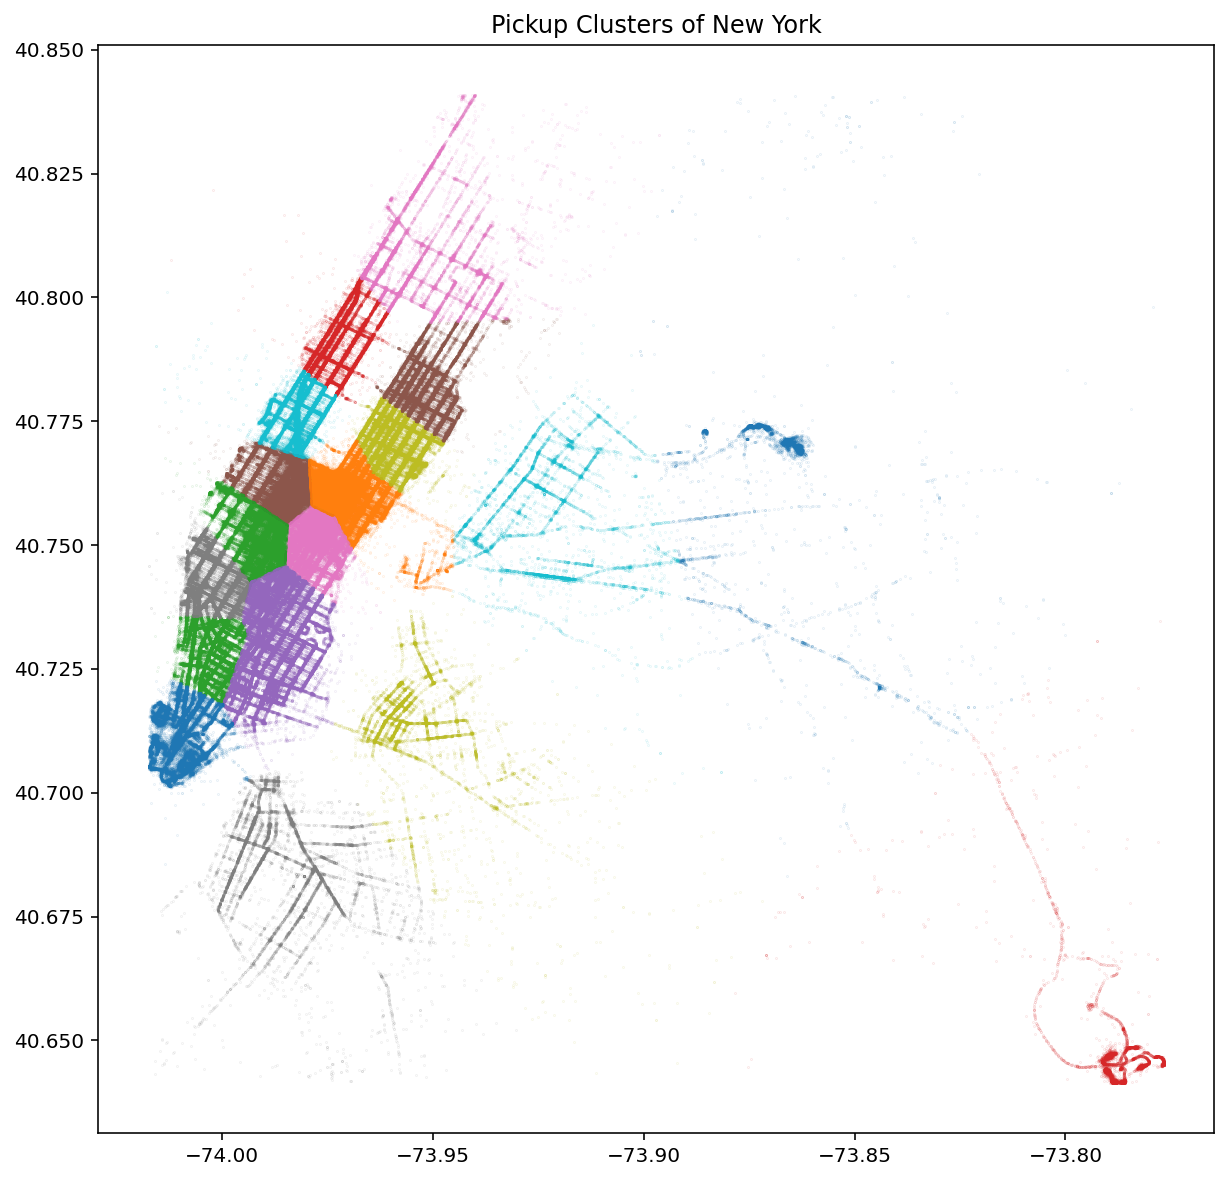

In [18]:
# Plot pickup 
temp_df = df.sample(1000000)
plt.figure(figsize = (10,10))
for label in temp_df.pickup_cluster.unique():
    plt.plot(temp_df.pickup_longitude[temp_df.pickup_cluster == label],temp_df.pickup_latitude[df.pickup_cluster == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Pickup Clusters of New York')
plt.show()

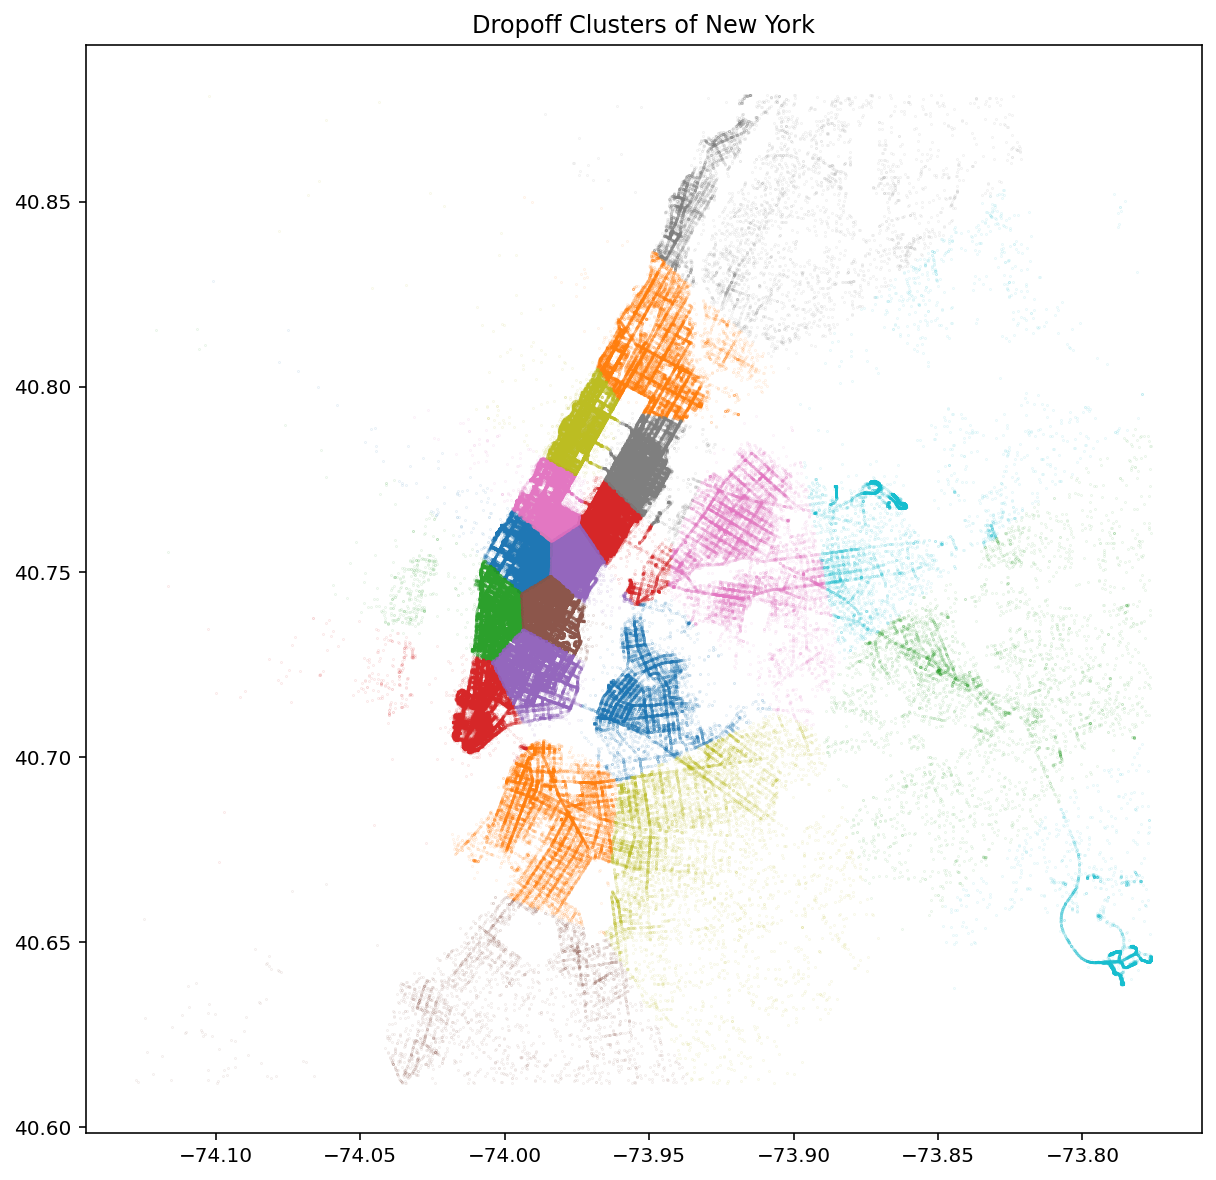

In [19]:
# Dropoff pickup 
temp_df = df.sample(1000000)
plt.figure(figsize = (10,10))
for label in temp_df.dropoff_cluster.unique():
    plt.plot(temp_df.dropoff_longitude[temp_df.dropoff_cluster == label],temp_df.dropoff_latitude[df.dropoff_cluster == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Dropoff Clusters of New York')
plt.show()

In [23]:
# Plot Map
def number_DivIcon(color, number):
    """ Create a 'numbered' icon

    """
    icon = DivIcon(
        icon_size=(150, 36),
        icon_anchor=(14, 40),
        #             html='<div style="font-size: 18pt; align:center, color : black">' + '{:02d}'.format(num+1) + '</div>',
        html="""<span class="fa-stack " style="font-size: 12pt" >>
                    <!-- The icon that will wrap the number -->
                    <span class="fa fa-circle-o fa-stack-2x" style="color : {:s}"></span>
                    <!-- a strong element with the custom content, in this case a number -->
                    <strong class="fa-stack-1x">
                         {:02d}  
                    </strong>
                </span>""".format(color, number)
    )
    return icon


col_hex = ['#488154', '#d25b1b']  # green, red

lat_center = 40.78
lon_center = -73.62

map_nyc = folium.Map(location=[lat_center, lon_center],
                     tiles="openstreetmap", max_zoom=15, zoom_start=10)


for i in range(0, 20):

    p1 = (PickupCluster.cluster_centers_[
          :, :2][i][0], PickupCluster.cluster_centers_[:, :2][i][1])

    p2 = (DropCluster.cluster_centers_[:, :2][i]
          [0], DropCluster.cluster_centers_[:, :2][i][1])

    folium.Marker(location=p1,
                  icon=number_DivIcon(col_hex[1], i),
                  popup="Pick up = " + str(i),
                  ).add_to(map_nyc)  # red

    folium.Marker(location=p2,
                  icon=number_DivIcon(col_hex[0], i),
                  popup="Drop off = " + str(i)).add_to(map_nyc)

#     folium.PolyLine(locations = [p1,p2] ,
#                     color = "red",opacity = .6,
#                    ).add_to(map_nyc)

#     folium.Circle(
#         location=p1,
#         color= "green", radius = 400,
#         fill=True,
#         opacity=1).add_to(map_nyc)

#     folium.Circle(
#         location=p2,
#         color= "blue", radius = 400,
#         fill=True,
#         opacity=1).add_to(map_nyc)


map_nyc

In [28]:
# PLOT
temp = df.groupby('pickup_cluster')['pickup_longitude'].count()


fig = px.bar(temp.index,temp.values, color=['black', 'red', 'green', 'blue', 'cyan']*4, labels={'index' : 'Cluster', 'x':'Number of trips'})
fig.update_layout(title_text="Number of trips starting from a cluster", showlegend=False)

In [29]:
# PLOT
temp = df.groupby('dropoff_cluster')['pickup_longitude'].count()


fig = px.bar(temp.index,temp.values, color=['black', 'red', 'green', 'blue', 'cyan']*4, labels={'index' : 'Cluster', 'x':'Number of trips'})
fig.update_layout(title_text="Number of trips finishing in a cluster", showlegend=False)

In [31]:
# Plot
temp = (df.groupby(['pickup_cluster', 'dayOfWeek'])['medallion'].count())
temp = temp.reset_index()
temp["pickup_cluster"] = temp["pickup_cluster"].astype(str)
fig = px.bar(temp, x='dayOfWeek', y='medallion', color='pickup_cluster',
       barmode='group', labels={'medallion': 'Count'})
fig.update_layout(title_text="Number of pickups everyday")

In [49]:
# Plot 
temp1 = df[df['dayOfWeek'] < 5]
temp = (temp1.groupby(['pickup_cluster', 'hourOfDay'])['medallion'].count())
temp = temp.reset_index()
temp["pickup_cluster"] = temp["pickup_cluster"].astype(str)
temp["hourOfDay"] = temp["hourOfDay"].astype(str)
fig = px.bar(temp, x='hourOfDay', y='medallion', color='pickup_cluster',
       barmode='group', labels={'medallion': 'Count'})
fig.update_layout(title_text="Number of Pickups Everyhour (WeekDay)")

In [51]:
# Plot 
temp1 = df[df['dayOfWeek'] > 4]
temp = (temp1.groupby(['pickup_cluster', 'hourOfDay'])['medallion'].count())
temp = temp.reset_index()
temp["pickup_cluster"] = temp["pickup_cluster"].astype(str)
temp["hourOfDay"] = temp["hourOfDay"].astype(str)
fig = px.bar(temp, x='hourOfDay', y='medallion', color='pickup_cluster',
       barmode='group', labels={'medallion': 'Count'})
fig.update_layout(title_text="Number of Pickups Everyhour (Weekend)")

In [33]:
# Plot 
temp = (df.groupby(['dropoff_cluster', 'dayOfWeek'])['medallion'].count())
temp = temp.reset_index()
temp["dropoff_cluster"] = temp["dropoff_cluster"].astype(str)
px.bar(temp, x='dayOfWeek', y='medallion', color='dropoff_cluster',
       barmode='group', labels={'medallion': 'Count'})
fig.update_layout(title_text="Number of Dropoffs everyday")

In [36]:
# Plot 
temp = (df.groupby(['dropoff_cluster', 'dst hourOfDay'])['medallion'].count())
temp = temp.reset_index()
temp["dropoff_cluster"] = temp["dropoff_cluster"].astype(str)
px.bar(temp, x='dst hourOfDay', y='medallion', color='dropoff_cluster',
       barmode='group', labels={'medallion': 'Count'})
fig.update_layout(title_text="Number of Dropoffs everyhour")

In [58]:
# plot
temp = pd.DataFrame(df.groupby(['pickup_cluster', 'dropoff_cluster'])['total_amount'].median())
temp = temp.reset_index()
fig = px.scatter(temp, x='pickup_cluster', y='dropoff_cluster', color='total_amount')
fig.update_layout(title_text="Median Fare")